In [2]:
import numpy as np
from qiskit import BasicAer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from qiskit.opflow import X, Z, I
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

from qiskit.utils import algorithm_globals
seed = 50
algorithm_globals.random_seed = seed
ql = QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
opt = SLSQP(maxiter=10000)
vqe = VQE(ansatz=ansatz, optimizer=opt, quantum_instance=ql, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(H2_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 65,
    'eigenstate': array([ 9.55277630e-05+1.20831580e-16j, -9.93766274e-01-6.20946313e-16j,
        1.11483552e-01+1.56591182e-16j,  1.77205662e-05+5.15495149e-17j]),
    'eigenvalue': (-1.8572750175622592+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[5]): 1.568325899115838,
                              ParameterVectorElement(θ[1]): 4.426962247694158,
                              ParameterVectorElement(θ[2]): 0.5470754456894421,
                              ParameterVectorElement(θ[4]): -2.598325679789499,
                              ParameterVectorElement(θ[6]): -4.717618329836427,
                              ParameterVectorElement(θ[0]): 4.296520325508546,
                              ParameterVectorElement(θ[7]): 0.3602072545900678,
                              ParameterVectorElement(θ[3]): 6.092947739750155},
    'optimal_point': array([ 4.29652033,  4.42696225,  0.54707545,  6.09294774, -2.5

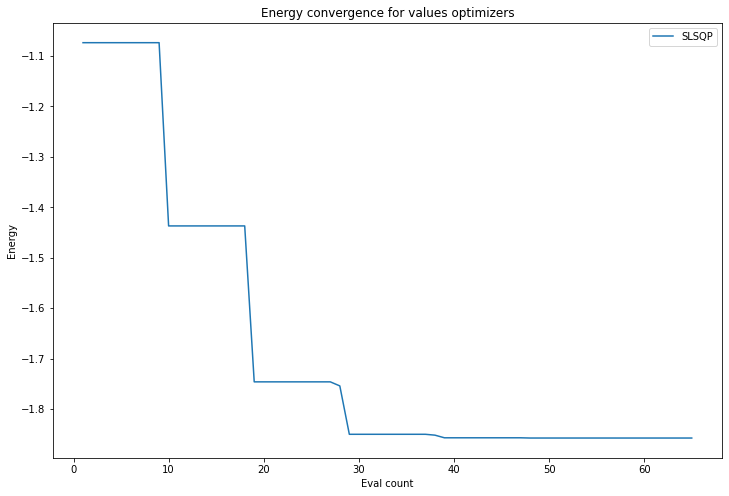

In [7]:
import pylab as pl
pl.rcParams['figure.figsize'] = (12, 8)
pl.plot(counts, values, label='SLSQP')
pl.xlabel('Eval count')
pl.ylabel('Energy')
pl.title('Energy convergence for values optimizers')
pl.legend(loc='upper right')


In [52]:
from scipy.linalg import expm
import numpy.linalg as LA
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import X, Y, Z, I
def create_hamiltonian(Nq, cn, gamma, Bn):
    
    hamiX = 0.5*cn[0]*(1+gamma)*(X ^ X ^ I ^ I ^ I)
    hamiX = hamiX + 0.5*cn[1]*(1+gamma)*(I ^ X ^ X ^ I ^ I)
    hamiX = hamiX + 0.5*cn[2]*(1+gamma)*(I ^ I ^ X ^ X ^ I)
    hamiX = hamiX + 0.5*cn[3]*(1+gamma)*(I ^ I ^ I ^ X ^ X)
    hamiY = 0.5*cn[0]*(1-gamma)*(Y ^ Y ^ I ^ I ^ I)
    hamiY = hamiX + 0.5*cn[1]*(1-gamma)*(I ^ Y ^ Y ^ I ^ I)
    hamiY = hamiX + 0.5*cn[2]*(1-gamma)*(I ^ I ^ Y ^ Y ^ I)
    hamiY = hamiX + 0.5*cn[3]*(1-gamma)*(I ^ I ^ I ^ Y ^ Y)
    hamiZ = Bn[0]*(Z ^ I ^ I ^ I ^ I)
    hamiZ = hamiZ + Bn[1]*(I ^ Z ^ I ^ I ^ I)
    hamiZ = hamiZ + Bn[2]*(I ^ I ^ Z ^ I ^ I)
    hamiZ = hamiZ + Bn[3]*(I ^ I ^ I ^ Z ^ I)
    hamiZ = hamiZ + Bn[4]*(I ^ I ^ I ^ I ^ Z)
    
    return hamiX + hamiY + hamiZ

def create_hamiltonian2(Nq, cn, gamma, Bn):
    '''
    create Hamiltonian gate
    target Hamiltonian is H=1/2*cn((1+gamma)XX+(1-gamma)YY)+BnZn
    Nq -> number of qubit
    cn -> coupling constant
    gamma -> parameter
    Bn -> Magnetic field
    '''
    
    XX= np.array(np.zeros(2**Nq))
    YY= np.array(np.zeros(2**Nq))
    Zn= np.array(np.zeros(2**Nq))
    Identity = 'I' * Nq
    hamiltonian = np.array(np.zeros(2**Nq))
    
    for k in range(0, Nq):
        '''
        隣あうqubitのみ相互作用するようなモデルを考える
        0 1 2 ... k-1 X X k+2 ... N-1
        0 1 2 ... k-1 Y Y k+2 ... N-1
        '''
        
        # 端まで計算したらスキップ
        if k == Nq-1:
            continue

        hamiX = Pauli(Identity[:k] + 'XX' + Identity[k+2:])
        hamiY = Pauli(Identity[:k] + 'YY' + Identity[k+2:])

        XX = XX + 0.5*cn[k]*(1+gamma)*hamiX.to_matrix()
        YY = YY + 0.5*cn[k]*(1-gamma)*hamiY.to_matrix()

    for k in range(0, Nq):
        hamiZ = Pauli(Identity[:k] + 'Z' + Identity[k+1:])
        Zn = Zn + Bn[k] * hamiZ.to_matrix()
    
    return XX + YY + Zn

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from math import pi
def create_ansatz(q,cn,r,bn):
    theta = Parameter('θ')
    time = Parameter('t')
    qc = QuantumCircuit(q)
    qc.cx(0, 1)
    qc.rx(theta,[0,1])
    qc.ry(theta,[0,1])
    hami = expm(-1j*create_hamiltonian2(q,cn,r,bn)*time)
    qc.append(Operator(hami),list(range(q)))
    return qc


In [53]:
import numpy as np
from qiskit import BasicAer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

qubit = 5
cn = [1] * qubit
r = 0
bn = [0] * qubit

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

from qiskit.utils import algorithm_globals
seed = 50
algorithm_globals.random_seed = seed
ql = QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

ansatz = create_ansatz(qubit, cn, r, bn)
opt = SLSQP(maxiter=10000)
vqe = VQE(ansatz=ansatz, optimizer=opt, quantum_instance=ql, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(create_hamiltonian(qubit, cn, r, bn))
print(result)

TypeError: ParameterExpression with unbound parameters ({Parameter(t)}) cannot be cast to a float.

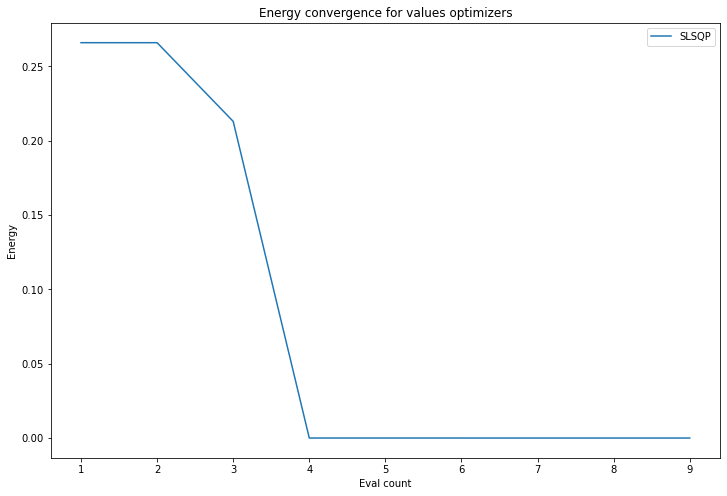

In [28]:
import pylab as pl
pl.rcParams['figure.figsize'] = (12, 8)
pl.plot(counts, values, label='SLSQP')
pl.xlabel('Eval count')
pl.ylabel('Energy')
pl.title('Energy convergence for values optimizers')
pl.legend(loc='upper right')

In [11]:
from qiskit.opflow import X, Y, Z, I
from qiskit.opflow.primitive_ops import PauliOp

Nq = 5
for k in range(0, Nq):
    print('k = %s' % k)
    if k == Nq-1:
        break
    elif k == 0:
        hamiX = X ^ X
        hamiY = Y ^ Y
        for l in range(k+2, Nq):
            hamiX = hamiX ^ I
            hamiY = hamiY ^ I
    else:
        hamiX = I
        hamiY = I
        for l in range(1, k):
            hamiX = hamiX ^ I
            hamiY = hamiY ^ I
        
        hamiX = hamiX ^ X ^ X
        hamiY = hamiY ^ Y ^ Y

        for l in range(k+2, 5):
            hamiX = hamiX ^ I
            hamiY = hamiY ^ I
    
    print(-1j*(hamiX)*1)
    print(hamiY)


k = 0
-1j * XXIII
YYIII
k = 1
-1j * IXXII
IYYII
k = 2
-1j * IIXXI
IIYYI
k = 3
-1j * IIIXX
IIIYY
k = 4
